<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/CLV_Conformal_Prediction_Segmentation/CLV_CONFORMAL_PREDICTION_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [1]:
! pip install shap &> /dev/null

In [2]:
! pip install feature_engine &>/dev/null

In [3]:
! pip install optuna &>/dev/null

In [4]:
! pip install MAPIE &>/dev/null

In [5]:
! pip install scikit-learn-extra &>/dev/null

In [6]:
! pip install dtaidistance &>/dev/null

In [7]:
! pip install gower &>/dev/null

In [8]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import scipy
from scipy.stats import shapiro
import scipy.stats as stats
import feature_engine
from feature_engine.timeseries.forecasting import WindowFeatures
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import TweedieRegressor
import lightgbm
import xgboost
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import mapie
from mapie.metrics import (coverage_width_based, regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_squared_error
import statsmodels
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import gower
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import dtaidistance
from dtaidistance import dtw
from sklearn.manifold import Isomap
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import optuna
import shap


import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [9]:
np.__version__

'1.26.4'

In [10]:
pd.__version__

'2.2.2'

In [11]:
matplotlib.__version__

'3.8.0'

In [12]:
sns.__version__

'0.13.2'

In [13]:
scipy.__version__

'1.13.1'

In [14]:
feature_engine.__version__

'1.8.1'

In [15]:
sklearn.__version__

'1.5.2'

In [16]:
lightgbm.__version__

'4.5.0'

In [17]:
xgboost.__version__

'2.1.2'

In [18]:
mapie.__version__

'0.9.1'

In [19]:
statsmodels.__version__

'0.14.4'

In [20]:
dtaidistance.__version__

'2.3.12'

In [21]:
optuna.__version__

'4.0.0'

In [22]:
shap.__version__

'0.46.0'

In [23]:
# dataset
df_0=pd.read_csv('/content/AutoInsurance.csv',index_col=0)

### Data Cleaning & Handling Variables

In [24]:
# Cast datetime variable in datetime format
df_1 = df_0.copy()
# Reset index to bring `Customer` into the columns
df_1 = df_1.reset_index()
df_1['Effective_Date'] = pd.to_datetime(df_1['Effective To Date'])
df_1.set_index(['Effective_Date'], inplace=True)
df_1 = df_1.sort_values(by='Effective_Date')
# Sanity check: data span
df_1.index.min(), df_1.index.max()


(Timestamp('2011-01-01 00:00:00'), Timestamp('2011-12-02 00:00:00'))

In [25]:
df_1 = df_1.drop(['Customer','Effective To Date'], axis=1)

In [26]:
# Rename some features for a practical use
df_2 = df_1.copy()
df_2 = df_2.rename(columns={"Customer Lifetime Value":"Customer_Lifetime_Value","Location Code":"Location_Code","Marital Status":"Marital_Status","Monthly Premium Auto":"Monthly_Premium_Auto","Months Since Last Claim":"Months_Since_Last_Claim",
                           "Months Since Policy Inception":"Months_Since_Policy_Inception","Number of Open Complaints":"Number_of_Open_Complaints","Number of Policies":"Number_of_Policies",
                           "Policy Type":"Policy_Type","Renew Offer Type":"Renew_Offer_Type","Sales Channel":"Sales_Channel","Total Claim Amount":"Total_Claim_Amount",
                           "Vehicle Class":"Vehicle_Class","Vehicle Size":"Vehicle_Size"})

In [27]:
df_encoded=df_2.copy()

### Functions

In [28]:
def calculate_predictions_and_scores(Model, X_test, alpha):
  # Make predictions on the test data
  y_pred, y_pis = Model.predict(X_test, alpha=alpha, ensemble=True, optimize_beta=True)


  # Set negative prediction intervals to zero
  y_pis = y_pis.clip(min=1e-12)
  y_pred = y_pred.clip(min=1e-12)

  # Store predictions in a dataframe
  predictions = y_test.to_frame()
  predictions.columns = ['y_true']
  predictions["point_prediction"] = y_pred
  predictions["lower"] = y_pis.reshape(-1, 2)[:, 0]
  predictions["upper"] = y_pis.reshape(-1, 2)[:, 1]

  # Calculate the coverage and width of the prediction intervals
  coverage = regression_coverage_score(
      y_test,
      y_pis[:, 0, 0],
      y_pis[:, 1, 0]
  )
  width = regression_mean_width_score(
      y_pis[:, 0, 0],
      y_pis[:, 1, 0]
  )

  # Calculate mgd for lower, point, and upper predictions
  mgd_lower = mean_gamma_deviance(predictions[['y_true']], predictions[['lower']])
  mgd_median = mean_gamma_deviance(predictions[['y_true']], predictions[['point_prediction']])
  mgd_upper = mean_gamma_deviance(predictions[['y_true']], predictions[['upper']])

  results = {
        "coverage": coverage,
        "width": width,
        "mgd_lower": mgd_lower,
        "mgd_median": mgd_median,
        "mgd_upper": mgd_upper
  }

  return results, predictions  # Return results and predictions separately

In [29]:
# Metrics
def calculate_metrics(model, X_train, y_train, X_test, y_test, weight_train=None, weight_test=None, model_name='Model'):
    # Function to calculate WMAPE
    def wmape(y_true, y_pred, sample_weight=None):
        absolute_errors = np.abs(y_true - y_pred)
        if sample_weight is not None:
            return np.sum(absolute_errors * sample_weight) / np.sum(y_true * sample_weight)
        else:
            return np.sum(absolute_errors) / np.sum(y_true)

    # Predictions
    y_tr_pred = model.predict(X_train)
    y_te_pred = model.predict(X_test)


    # Metrics
    rmse_train = np.sqrt(mean_squared_error(y_train, y_tr_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_te_pred))
    mgd_train = mean_gamma_deviance(y_train, y_tr_pred)
    mgd_test = mean_gamma_deviance(y_test, y_te_pred)
    wmape_train = wmape(y_train, y_tr_pred, sample_weight=weight_train)
    wmape_test = wmape(y_test, y_te_pred, sample_weight=weight_test)

    # Create a DataFrame to store the metrics
    results_df = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test,
        'wmape_train': wmape_train,
        'wmape_test': wmape_test
    }

    return results_df


In [30]:
# Define a function to print results with a title
def print_with_title(df, title):
    print(f"{title}\n")
    print(df)


In [31]:
# Function to calculate errors for a single model's predictions
def calculate_single_model_errors(predictions):
    error_lower = predictions["point_prediction"] - predictions["lower"]
    error_upper = predictions["upper"] - predictions["point_prediction"]

    # Ensure no negative values in yerr. If negative, make them zero.
    error_lower = np.maximum(error_lower, 0)
    error_upper = np.maximum(error_upper, 0)

    # Combine lower and upper errors into one array
    error = [error_lower, error_upper]
    return error

# Function to plot error of a single model
def plot_single_model_error(model_name, predictions):
    error = calculate_single_model_errors(predictions)

    fig, ax = plt.subplots(figsize=(5, 5))

    ax.errorbar(predictions["y_true"], predictions["point_prediction"],
                yerr=error,
                ecolor='gray', linestyle='', marker="o", capsize=8)

    ax.axline([0, 0], [1, 1], color="red", linestyle='--', lw=3, zorder=3)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel('True Value', fontsize=10)
    ax.set_ylabel('Predicted Value', fontsize=10)
    ax.set_title(f'{model_name} Method', fontsize=12)

    # Set the font size of x-axis and y-axis
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    plt.show()


In [32]:
def plot_cltv_with_cp(y, predictions):

  # Group the true values and prediction data by week
  y_group = y.groupby(pd.Grouper(freq='W')).sum()
  predictions_group = predictions.groupby(pd.Grouper(freq='W')).sum()

  # Plot true values
  plt.figure(figsize=(5, 5))
  plt.plot(y_group, label='True CLTV', marker='o', color='blue')

  # Plot point predictions
  plt.plot(predictions_group.index, predictions_group['point_prediction'], label='Predicted CLTV', color='red')

  # Plot prediction intervals
  plt.fill_between(
      predictions_group.index,
      predictions_group['lower'],
      predictions_group['upper'],
      color='green',
      alpha=0.3,
      label='Prediction Interval'
  )

  # Customize the plot
  plt.title('Customer Lifetime Value Conformal Prediction', fontsize=12)
  plt.xlabel('Week', fontsize=10)
  plt.ylabel('CLTV',fontsize=10)
  plt.xticks(rotation=45, fontsize=10)
  plt.grid(True)

  # Set the legend
  plt.legend(loc='upper left', fontsize=8)

  # Show the plot
  plt.tight_layout()
  plt.show()

In [33]:
# Function to calculate errors for a single model's predictions
def calculate_single_model_errors(predictions):
    error_lower = predictions["point_prediction"] - predictions["lower"]
    error_upper = predictions["upper"] - predictions["point_prediction"]

    # Ensure no negative values in yerr. If negative, make them zero.
    error_lower = np.maximum(error_lower, 0)
    error_upper = np.maximum(error_upper, 0)

    # Combine lower and upper errors into one array
    error = [error_lower, error_upper]
    return error

# Combined function to create both plots
def cltv_combined_plots(model_name, y, predictions):
    # Calculate errors for the first plot
    error = calculate_single_model_errors(predictions)

    # Create a single figure with two subplots (stacked vertically)
    fig, axs = plt.subplots(2, 1, figsize=(7, 6), constrained_layout=True)

    # First subplot: Error plot
    ax1 = axs[0]
    ax1.errorbar(predictions["y_true"], predictions["point_prediction"],
                 yerr=error,
                 ecolor='gray', linestyle='', marker="o", capsize=8)

    ax1.axline([0, 0], [1, 1], color="red", linestyle='--', lw=3, zorder=3)
    ax1.set_xlim(0)
    ax1.set_ylim(0)
    ax1.set_xlabel('True Value', fontsize=10)
    ax1.set_ylabel('Predicted Value', fontsize=10)
    ax1.set_title(f'{model_name} Method', fontsize=12)
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)

    # Second subplot: CLTV plot
    ax2 = axs[1]
    y_group = y.groupby(pd.Grouper(freq='W')).sum()
    predictions_group = predictions.groupby(pd.Grouper(freq='W')).sum()

    ax2.plot(y_group, label='True CLTV', marker='o', color='blue')
    ax2.plot(predictions_group.index, predictions_group['point_prediction'], label='Predicted CLTV', color='red')

    ax2.fill_between(
        predictions_group.index,
        predictions_group['lower'],
        predictions_group['upper'],
        color='green',
        alpha=0.3,
        label='Prediction Interval'
    )

    ax2.set_title('Customer Lifetime Value Conformal Prediction', fontsize=12)
    ax2.set_xlabel('Week', fontsize=10)
    ax2.set_ylabel('CLTV', fontsize=10)
    ax2.tick_params(axis='x', labelsize=10, rotation=45)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.grid(True)
    ax2.legend(loc='upper left', fontsize=8)

    # Show the combined plots
    plt.show()


In [34]:
def plot_coverage_width(Model, X_test):
  # Make predictions on the test data
  y_pred, y_pis = Model.predict(X_test, alpha=alpha, ensemble=True, optimize_beta=True)


  # Ensure prediction intervals are positive
  y_pis = y_pis.clip(min=1e-12)
  y_pred = y_pred.clip(min=1e-12)

  # Store predictions in a dataframe
  predictions = y_test.to_frame()
  predictions.columns = ['y_true']
  predictions["point_prediction"] = y_pred
  predictions["lower"] = y_pis.reshape(-1, 2)[:, 0]
  predictions["upper"] = y_pis.reshape(-1, 2)[:, 1]

  # Bin data using point predictions into 10 equally-sized bins
  predictions['bin'] = pd.qcut(predictions['point_prediction'], q=10, labels=False)

  # Calculate coverage and width for each bin
  coverage_per_bin = []
  width_per_bin = []

  bins = predictions['bin'].unique()
  for bin in bins:
      bin_data = predictions[predictions['bin'] == bin]
      coverage = regression_coverage_score(
          bin_data['y_true'],
          bin_data['lower'],
          bin_data['upper']
      )
      width = regression_mean_width_score(
          bin_data['lower'],
          bin_data['upper']
      )
      coverage_per_bin.append(coverage)
      width_per_bin.append(width)

  # Normalize width to [0, 1] by dividing by the maximum width
  max_width = max(width_per_bin)
  normalized_width_per_bin = [width / max_width for width in width_per_bin]

  # Plotting Coverage
  plt.figure(figsize=(6, 4))
  plt.bar(bins, coverage_per_bin, color='tab:red', alpha=0.6)
  plt.axhline(0.95, color='gray', linestyle='--')  # Add dashed line at 0.95
  plt.xlabel('Bins', fontsize=10)
  plt.ylabel('Coverage', fontsize=10)
  plt.title('Coverage of Prediction Intervals by Binned Predictions', fontsize=12)
  plt.xticks(bins)
  plt.ylim(0, 1)  # Ensure coverage y-axis is from 0 to 1
  plt.tight_layout()
  plt.show()

  # Plotting Normalized Width
  plt.figure(figsize=(6, 4))
  plt.bar(bins, normalized_width_per_bin, color='tab:blue', alpha=0.6)
  plt.xlabel('Bins', fontsize=10)
  plt.ylabel('Normalized Width', fontsize=10)
  plt.title('Normalized Width of Prediction Intervals by Binned Predictions', fontsize=12)
  plt.xticks(bins)
  plt.ylim(0, 1)  # Set y-axis to [0, 1] for normalized width
  plt.tight_layout()
  plt.show()

### Label Encoding

In [35]:
label_encoder_State = LabelEncoder()
label_encoder_Response = LabelEncoder()
label_encoder_Coverage = LabelEncoder()
label_encoder_Education = LabelEncoder()
label_encoder_EmploymentStatus = LabelEncoder()
label_encoder_Gender = LabelEncoder()
label_encoder_Location_Code = LabelEncoder()
label_encoder_Marital_Status = LabelEncoder()
label_encoder_Policy_Type = LabelEncoder()
label_encoder_Policy = LabelEncoder()
label_encoder_Renew_Offer_Type = LabelEncoder()
label_encoder_Sales_Channel = LabelEncoder()
label_encoder_Vehicle_Class = LabelEncoder()
label_encoder_Vehicle_Size = LabelEncoder()


df_encoded['State_ed'] = label_encoder_State.fit_transform(df_encoded['State'])
df_encoded['Response_ed'] = label_encoder_Response.fit_transform(df_encoded['Response'])
df_encoded['Coverage_ed'] = label_encoder_Coverage.fit_transform(df_encoded['Coverage'])
df_encoded['Education_ed'] = label_encoder_Education.fit_transform(df_encoded['Education'])
df_encoded['EmploymentStatus_ed'] = label_encoder_EmploymentStatus.fit_transform(df_encoded['EmploymentStatus'])
df_encoded['Gender_ed'] = label_encoder_Gender.fit_transform(df_encoded['Gender'])
df_encoded['Location_Code_ed'] = label_encoder_Location_Code.fit_transform(df_encoded['Location_Code'])
df_encoded['Marital_Status_ed'] = label_encoder_Marital_Status.fit_transform(df_encoded['Marital_Status'])
df_encoded['Policy_Type_ed'] = label_encoder_Policy_Type.fit_transform(df_encoded['Policy_Type'])
df_encoded['Policy_ed'] = label_encoder_Policy.fit_transform(df_encoded['Policy'])
df_encoded['Renew_Offer_Type_ed'] = label_encoder_Renew_Offer_Type.fit_transform(df_encoded['Renew_Offer_Type'])
df_encoded['Sales_Channel_ed'] = label_encoder_Sales_Channel.fit_transform(df_encoded['Sales_Channel'])
df_encoded['Vehicle_Class_ed'] = label_encoder_Vehicle_Class.fit_transform(df_encoded['Vehicle_Class'])
df_encoded['Vehicle_Size_ed'] = label_encoder_Vehicle_Size.fit_transform(df_encoded['Vehicle_Size'])

df_encoded = df_encoded.drop(['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus',
                             'Gender','Location_Code', 'Marital_Status', 'Policy_Type',
                             'Policy', 'Renew_Offer_Type', 'Sales_Channel',
                             'Vehicle_Class', 'Vehicle_Size'], axis=1)


In [36]:
target = df_encoded[['Customer_Lifetime_Value']]
X_all = df_encoded.drop(['Customer_Lifetime_Value'], axis=1)
X_all.shape

(9134, 21)

### Zero Variance Predictors

In [37]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) ==0]
to_drop

[]

In [38]:
# Drop features
X_all_v = X_all.drop(X_all[to_drop], axis=1)

### Normality Test

In [39]:
# normality test
stat, p = shapiro(X_all_v)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
  print('Sample looks Gaussian (fail to reject H0)')
else:
  print('Sample does not look Gaussian (reject H0)')

Statistics=0.169, p=0.000
Sample does not look Gaussian (reject H0)


In [40]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
corr_matrix = X_all.corr(method='spearman')
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['Policy_ed']

In [41]:
# Drop features
X_all_f = X_all.drop(X_all[to_drop], axis=1)

In [42]:
# Look at the new features data set
X_all_f.shape

(9134, 20)

### Feature Engineering with Lag, Rolling Window Features and Cycle Features

In [43]:
# Lag Features function
def lag_feat(df, var):
  df_lag = df.copy()
  lags = [1,7,12,30]
  outcomes = [var]
  df_lag=df_lag.assign(**{
      f'{col} (t-{lag})': df_lag[col].shift(lag)
      for lag in lags
      for col in outcomes})
  # Remove nan values
  df_lag = df_lag.dropna()
  return df_lag

In [44]:
# Rolling features function
def win_feat(df_lag, var):
  windows = [7,30]
  outcomes = [var]
  df_lag_win = df_lag.copy()
  for window in windows:
    for col in outcomes:
        df_lag_win[f"{col} (r_w-{window}) mean"] = df_lag_win[col].rolling(window=window).mean()
  # Remove nan values
  df_lag_win = df_lag_win.dropna()
  return df_lag_win

In [45]:
all = pd.concat([target, X_all_f], axis=1)

In [46]:
all_lag=lag_feat(all, 'Customer_Lifetime_Value')
all_lag_win=win_feat(all_lag, 'Customer_Lifetime_Value')
all_feat=all_lag_win.copy()

days_since_start = (all_feat.index - all_feat.index[0]).days
period=90
# Calculate sine and cosine components
all_feat['sin_3m'] = np.sin(2 * np.pi * days_since_start / period)
all_feat['cos_3m'] = np.cos(2 * np.pi * days_since_start / period)


In [47]:
y=all_feat.Customer_Lifetime_Value
X=all_feat.drop(['Customer_Lifetime_Value'], axis=1)

In [48]:
# Split data set train/test set : test set is built on the last 3 months to the end of the year
X_train = X[X.index <= '2011-09-30']
X_test = X[X.index >= '2011-09-01']
y_train = y[y.index <= '2011-09-30']
y_test = y[y.index >= '2011-09-01']
weight_train=X_train.Number_of_Policies
weight_test=X_test.Number_of_Policies
X_train_ = X_train.drop(['Number_of_Policies'], axis=1)
X_test_ = X_test.drop(['Number_of_Policies'], axis=1)


### GLM

#### Fine-tuning

In [49]:
# Fine tuning
#def objective(trial):
#    params = {
#        'power': 2,
#        'alpha': trial.suggest_loguniform('alpha', 1e-4, 1.0),
#        'link':'log'
#    }
#    np.random.seed(0)
#    glm = TweedieRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)
#    mgd_scores = []

#    for train_index, val_index in tscv.split(X_train):
#        X_tr, X_val, weight_tr, weight_val = X_train_.iloc[train_index], X_train_.iloc[val_index], weight_train.iloc[train_index],weight_train.iloc[val_index]
#        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

#        glm.fit(X_tr, y_tr, sample_weight=weight_tr)
#        pred_val = glm.predict(X_val)

#        mgd_score = mean_gamma_deviance(y_val, pred_val)
#        mgd_scores.append(mgd_score)

#    return np.mean(mgd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params


In [50]:
#best_params

#### GLM Optimized Estimator

In [51]:
np.random.seed(0)
glm_tuned = TweedieRegressor(power=2,  alpha= 0.0063251758319291685,link='log') # GLM with Gamma distribution
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
glm_model = GridSearchCV(glm_tuned,param_grid,cv=tscv)
glm_model_=glm_model.fit(X_train_, y_train, sample_weight=weight_train)

#### ENBPI Method

In [52]:
alpha = 0.05
gap = 1
mapie_cv = BlockBootstrap(
    n_blocks=10,
    overlapping=True,
    random_state=0
)

mapie_enbpi = MapieTimeSeriesRegressor(
    glm_model_,
    method="enbpi",
    cv=mapie_cv,
    agg_function="mean",
    n_jobs=-1
)


In [53]:
GLM_enbpi = mapie_enbpi.fit(X_train_, y_train, sample_weight=weight_train)

#### Prediction

In [54]:
GLM_enbpi_results, GLM_enbpi_predictions_df = calculate_predictions_and_scores(GLM_enbpi,X_test_,alpha)


In [55]:
GLM_results=calculate_metrics(glm_model_, X_train_, y_train, X_test_, y_test, weight_train, weight_test, model_name='GLM Model')

#### Results

In [56]:
print_with_title(pd.DataFrame([GLM_results]), "GLM results mean prediction")

GLM results mean prediction

    rmse_train    rmse_test  mgd_train  mgd_test  wmape_train  wmape_test
0  6122.412562  6056.667787   0.370658  0.373405     0.354208    0.362012


In [57]:
print_with_title(pd.DataFrame([GLM_enbpi_results]), "GLM enbpi results on Conformal Prdiction")

GLM enbpi results on Conformal Prdiction

   coverage         width     mgd_lower  mgd_median  mgd_upper
0  0.953958  24108.281391  5.435562e+15    0.366147   1.406132


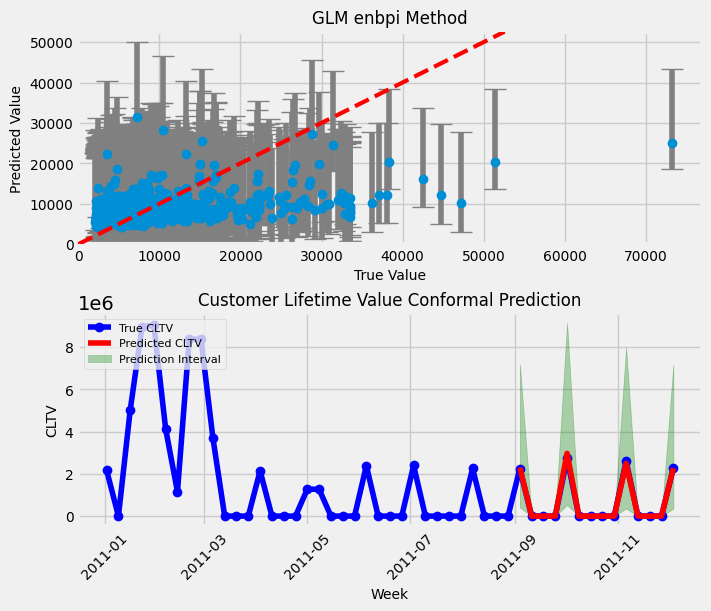

In [58]:
cltv_combined_plots('GLM enbpi', y, GLM_enbpi_predictions_df)

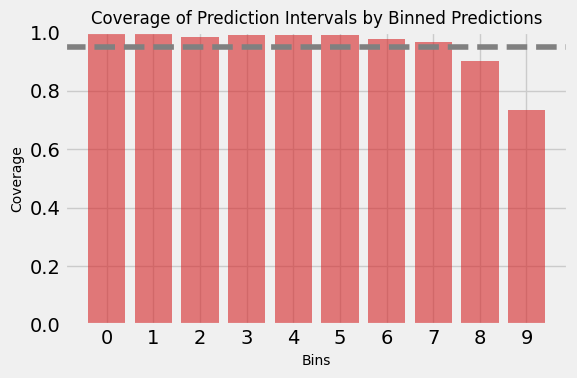

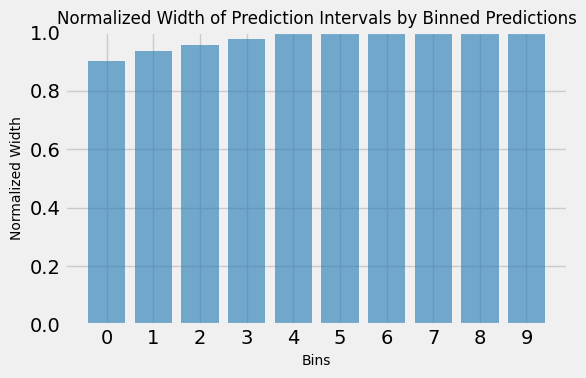

In [59]:
plot_coverage_width(GLM_enbpi, X_test_)

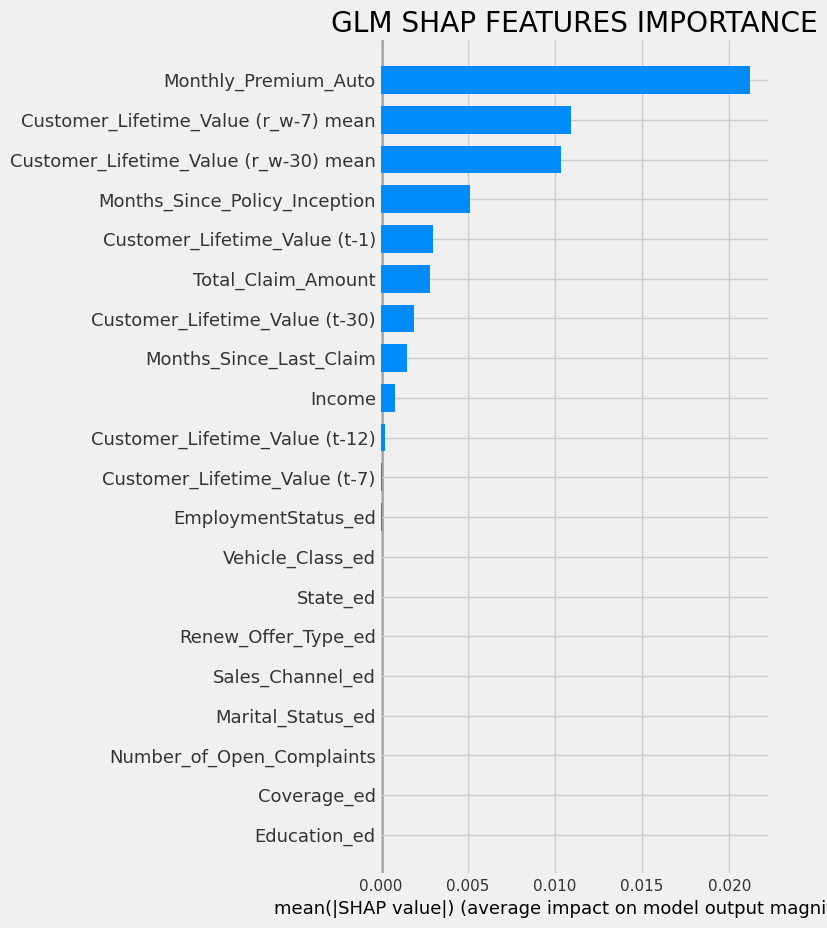

In [60]:
# Create and fit a Estimator with specified parameters
GLM_ = TweedieRegressor(power=2, alpha= 0.0063251758319291685, link='log').fit(X_train_, np.log1p(y_train),sample_weight=weight_train)
# Create a SHAP masker for the model
masker = shap.maskers.Independent(X_train_)
# Create a SHAP explainer for the model
GLM_explainer = shap.LinearExplainer(GLM_, masker=masker)
# Calculate SHAP values for the test dataset
GLM_shap_values = GLM_explainer.shap_values(X_test_)
# Set figure size for the plot
plt.rcParams['figure.figsize'] = (5,5)
# Set title for the SHAP feature importance plot
plt.title("GLM SHAP FEATURES IMPORTANCE")
# Plot SHAP summary plot for the model
shap.summary_plot(GLM_shap_values, features=X_test_, feature_names=X_test_.columns,plot_type='bar')

### LightGBM

#### Fine-Tuning

In [61]:
# Fine-tuning

#def objective(trial):
#    params = {
#        'objective': 'gamma',
#        'random_state': 0,
#        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#        'max_depth': trial.suggest_int('max_depth', 3, 8),
#        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
#        'bagging_fraction': trial.suggest_loguniform('bagging_fraction', 0.1, 1.0)
#    }

#    lgbm = LGBMRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)

#    mgd_scores = []


#    for train_index, val_index in tscv.split(X_train):
#      X_tr, X_val, weight_tr, weight_val = X_train_.iloc[train_index], X_train_.iloc[val_index], weight_train.iloc[train_index],weight_train.iloc[val_index]
#      y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]


#      lgbm.fit(X_tr, y_tr, sample_weight=weight_tr)
#      pred_val = lgbm.predict(X_val)

#      mgd_score = mean_gamma_deviance(y_val, pred_val)
#      mgd_scores.append(mgd_score)

#    return np.mean(mgd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params


In [62]:
#best_params

#### LightGBM Optimized Estimator

In [63]:
lgbm_tuned =  LGBMRegressor(
    n_estimators= 96,
    learning_rate= 0.05599805689903143,
    max_depth= 7,
    num_leaves= 84,
    min_child_samples= 91,
    min_data_in_leaf= 94,
    bagging_fraction= 0.25729644710075106,
    objective='gamma',
    verbose=-1,
    random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
lgbm_model = GridSearchCV(lgbm_tuned,param_grid,cv=tscv, verbose=0)
lgbm_model_=lgbm_model.fit(X_train_, y_train, sample_weight=weight_train)

#### ENBPI Method

In [64]:
alpha = 0.05
gap = 1
mapie_cv = BlockBootstrap(
    n_blocks=10,
    overlapping=True,
    random_state=0
)

mapie_enbpi = MapieTimeSeriesRegressor(
    lgbm_model_,
    method="enbpi",
    cv=mapie_cv,
    agg_function="mean",
    n_jobs=-1
)

In [65]:
LGBM_enbpi = mapie_enbpi.fit(X_train_, y_train, sample_weight=weight_train)

#### Prediction

In [66]:
LGBM_results=calculate_metrics(lgbm_model_, X_train_, y_train, X_test_, y_test, weight_train, weight_test, model_name='LGBM Model')

In [67]:
LGBM_enbpi_results, LGBM_enbpi_predictions_df = calculate_predictions_and_scores(LGBM_enbpi,X_test_,alpha)

#### Results

In [68]:
print_with_title(pd.DataFrame([LGBM_results]), "LGBM results mean prediction")

LGBM results mean prediction

    rmse_train    rmse_test  mgd_train  mgd_test  wmape_train  wmape_test
0  5324.707711  5697.895719   0.271201  0.315775     0.271428     0.30321


In [69]:
print_with_title(pd.DataFrame([LGBM_enbpi_results]), "LGBM enbpi results on Conformal Prdiction")

LGBM enbpi results on Conformal Prdiction

   coverage         width     mgd_lower  mgd_median  mgd_upper
0  0.946688  23454.779638  5.678473e+15    0.312886   1.368755


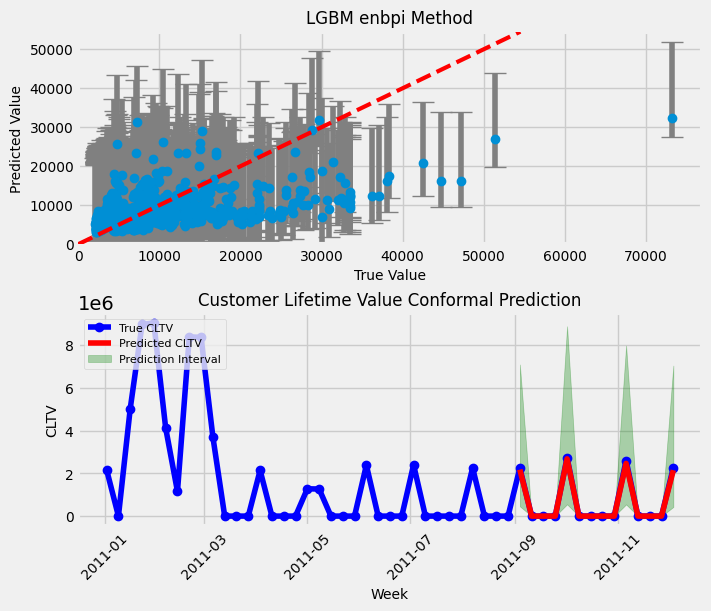

In [70]:
cltv_combined_plots('LGBM enbpi', y, LGBM_enbpi_predictions_df)

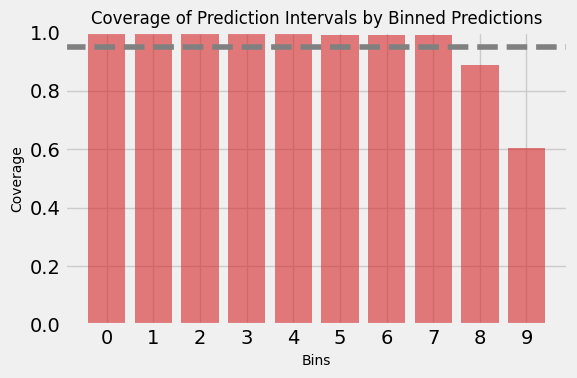

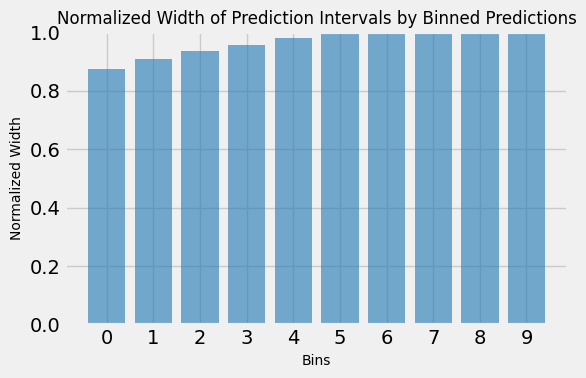

In [71]:
plot_coverage_width(LGBM_enbpi, X_test_)

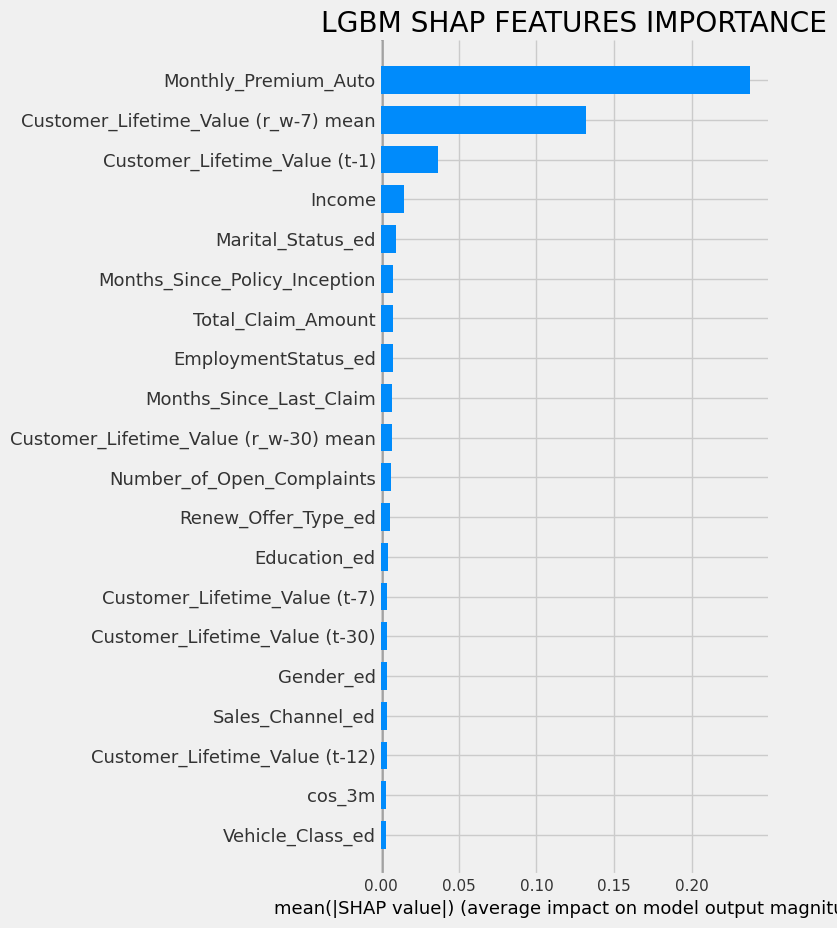

In [72]:
# Create and fit a Estimator with specified parameters
LGBM_ = LGBMRegressor(
    n_estimators= 96,
    learning_rate= 0.05599805689903143,
    max_depth= 7,
    num_leaves= 84,
    min_child_samples= 91,
    min_data_in_leaf= 94,
    bagging_fraction= 0.25729644710075106,
    objective='gamma',
    verbose=-1,
    random_state=0).fit(X_train_, y_train,sample_weight=weight_train)
# Create a SHAP explainer for the model
LGBM_explainer = shap.TreeExplainer(LGBM_)
# Calculate SHAP values for the test dataset
LGBM_shap_values = LGBM_explainer.shap_values(X_test_)
# Set figure size for the plot
plt.rcParams['figure.figsize'] = (5,5)
# Set title for the SHAP feature importance plot
plt.title("LGBM SHAP FEATURES IMPORTANCE")
# Plot SHAP summary plot for the LightGBM model
shap.summary_plot(LGBM_shap_values, features=X_test_, feature_names=X_test_.columns,plot_type='bar')

### XGBoost

#### Fine-tuning

In [73]:
# Fine-tuning

#def objective(trial):
#    params = {
#        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#        'max_depth': trial.suggest_int('max_depth', 3, 10),
#        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#        'objective': 'reg:gamma',
#        'random_state': 0
#    }

#    xgb = XGBRegressor(**params, n_jobs=-1)

#    tscv = TimeSeriesSplit(n_splits=5)

#    mgd_scores = []

#    for train_index, val_index in tscv.split(X_train):
#        X_tr = X_train_.iloc[train_index]
#        X_val = X_train_.iloc[val_index]
#        weight_tr = weight_train.iloc[train_index]
#        weight_val = weight_train.iloc[val_index]
#        y_tr = y_train.iloc[train_index]
#        y_val = y_train.iloc[val_index]

#        xgb.fit(X_tr, y_tr, sample_weight=weight_tr)
#        pred_val = xgb.predict(X_val)

#        mgd_score = mean_gamma_deviance(y_val, pred_val)
#        mgd_scores.append(mgd_score)

#    return np.mean(mgd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=30)

#best_params = study.best_params

In [74]:
#best_params

#### XGB Optimized Estimator

In [75]:
xgb_tuned = XGBRegressor(
  n_estimators= 228,
  max_depth= 3,
  learning_rate= 0.060462273075155074,
  subsample= 0.9554665585827192,
  colsample_bytree= 0.8479368267386574,
  min_child_weight= 5,
  objective='reg:gamma',
  random_state=0
)
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
xgb_model = GridSearchCV(xgb_tuned,param_grid,cv=tscv)
xgb_model_=xgb_model.fit(X_train_, y_train, sample_weight=weight_train)

#### ENBPI Method

In [76]:
alpha = 0.05
gap = 1
mapie_cv = BlockBootstrap(
    n_blocks=10,
    overlapping=True,
    random_state=0
)

mapie_enbpi = MapieTimeSeriesRegressor(
    xgb_model_,
    method="enbpi",
    cv=mapie_cv,
    agg_function="mean",
    n_jobs=-1
)


In [77]:
XGB_enbpi = mapie_enbpi.fit(X_train_, y_train, sample_weight=weight_train)

#### Prediction

In [78]:
XGB_enbpi_results, XGB_enbpi_predictions_df = calculate_predictions_and_scores(XGB_enbpi,X_test_,alpha)


In [79]:
XGB_results=calculate_metrics(xgb_model_, X_train_, y_train, X_test_, y_test, weight_train, weight_test, model_name='XGB Model')

#### Results

In [80]:
print_with_title(pd.DataFrame([XGB_results]), "XGB results mean prediction")

XGB results mean prediction

    rmse_train    rmse_test  mgd_train  mgd_test  wmape_train  wmape_test
0  5518.685249  5627.686715    0.30432  0.319762     0.288152    0.303075


In [81]:
print_with_title(pd.DataFrame([XGB_enbpi_results]), "XGB enbpi results on Conformal Prediction")

XGB enbpi results on Conformal Prediction

   coverage         width     mgd_lower  mgd_median  mgd_upper
0  0.943457  23395.710417  5.084347e+15    0.310799   1.366204


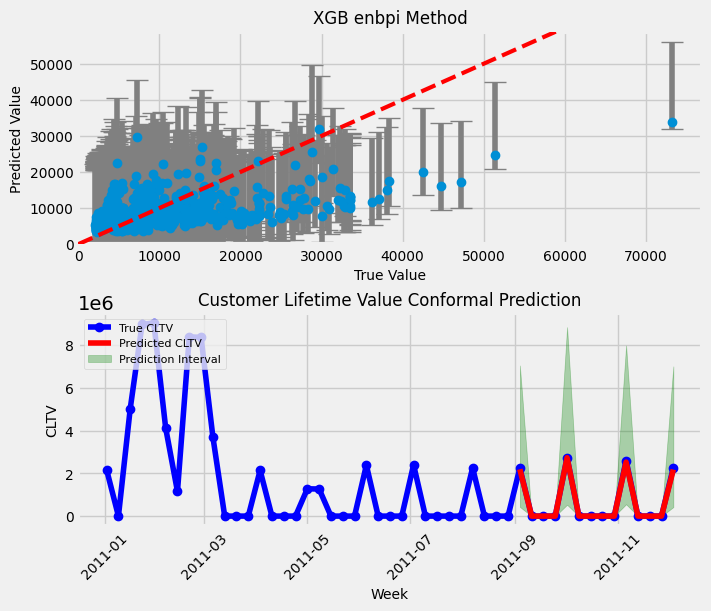

In [82]:
cltv_combined_plots('XGB enbpi', y, XGB_enbpi_predictions_df)

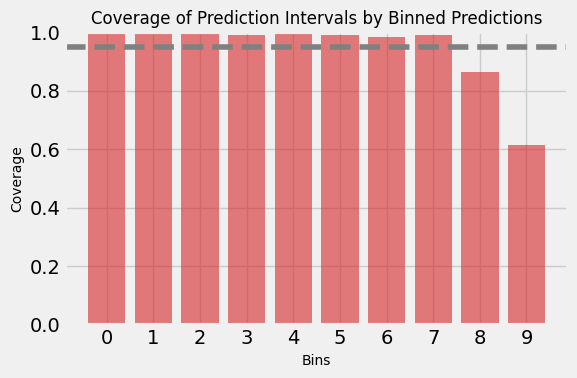

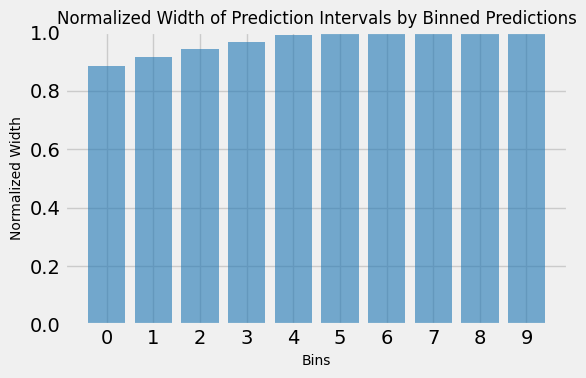

In [83]:
plot_coverage_width(XGB_enbpi, X_test_)

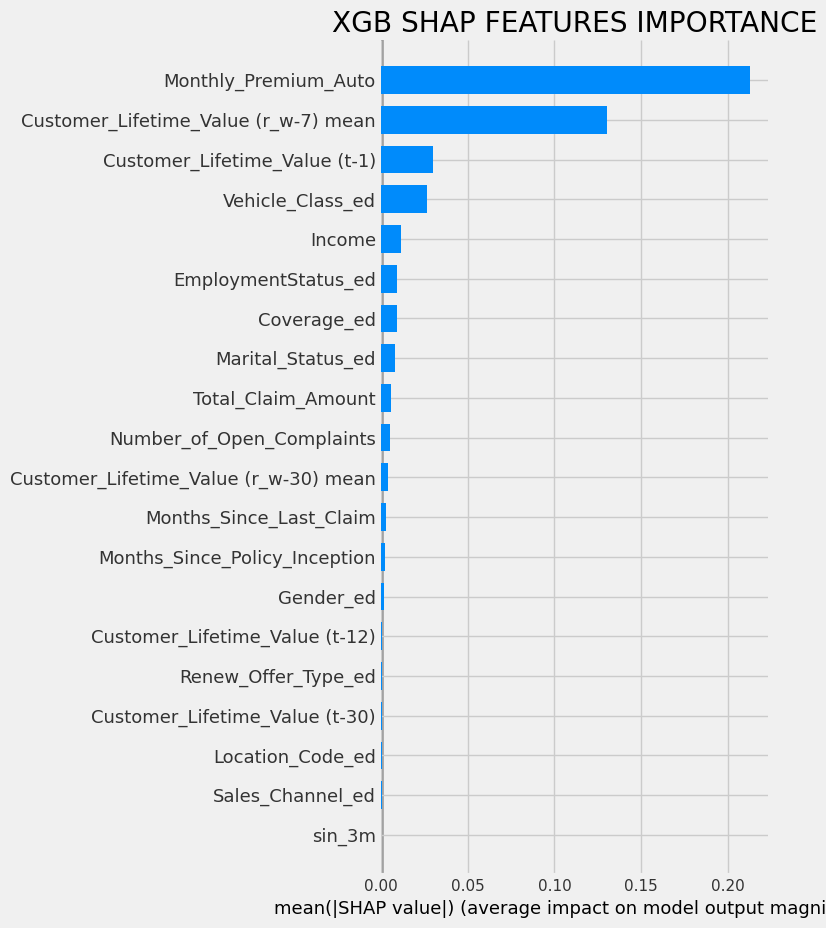

In [86]:
# Create and fit a Estimator with specified parameters
XGB_ = XGBRegressor(
  n_estimators= 228,
  max_depth= 3,
  learning_rate= 0.060462273075155074,
  subsample= 0.9554665585827192,
  colsample_bytree= 0.8479368267386574,
  min_child_weight= 5,
  objective='reg:gamma',
  random_state=0).fit(X_train_, y_train,sample_weight=weight_train)
# Create a SHAP explainer for the model
XGB_explainer = shap.TreeExplainer(XGB_)
# Calculate SHAP values for the test dataset
XGB_shap_values = XGB_explainer.shap_values(X_test_)
# Set figure size for the plot
plt.rcParams['figure.figsize'] = (5,5)
# Set title for the SHAP feature importance plot
plt.title("XGB SHAP FEATURES IMPORTANCE")
# Plot SHAP summary plot for the LightGBM model
shap.summary_plot(XGB_shap_values, features=X_test_, feature_names=X_test_.columns,plot_type='bar')

### References

https://mapie.readthedocs.io/en/latest/index.html

https://github.com/PacktPublishing/Practical-Guide-to-Applied-Conformal-Prediction

https://christophmolnar.com/books/conformal-prediction/

https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles